Vary this

1. Model params/layers
2. No. training epochs
3. Shuffling training data
4. Reduce/filter away None events
5. Change the size and position of the event start/end range


Also try moving all the events markers to line up correctly. Maybe aim to have the markers align in the first peak/trough?


In [2]:
import numpy as np
import pandas as pd
import wave
import math
import matplotlib.pyplot as plt
import tensorflow as tf

from data_ml import get_ml_data
from data_plot import plot_samples_events_individual

In [14]:
BRAINBOX_SAMPLE_RATE = 10000

EVENT_ID_MAP = {
    None: 0,
    "L": 1,
    "R": 2,
    "S": 3,
}
EVENT_ID_LETTER_MAP = {EVENT_ID_MAP[i]:i for i in EVENT_ID_MAP}

EVENT_COLOR_MAP = {
    None: "black",
    "L": "red",
    "R": "blue",
    "S": "green",
}

EVENT_ID_NAME_MAP = {
    0: "Nothing",
    1: "Left Wink",
    2: "Right Wink",
    3: "Dbl Blink",
}

EVENTS_PATH = "../src/data_collection/data/events/"
SAMPLES_PATH = "../src/data_collection/data/waves/"

# "DATA_2022-05-12_Josh_0001_0_1652333343",
# "DATA_2022-05-12_Josh_0001_0_1652333800",
# "DATA_2022-05-12_Josh_0001_1_1652334198",
# "DATA_2022-05-12_Josh_0001_1_1652334982",
# "DATA_2022-05-12_Josh_0001_2_1652335485",
# "DATA_2022-05-12_Josh_0001_2_1652336009",
# "DATA_2022-05-13_Josh_0001_3_1652400625",
# "DATA_2022-05-13_Josh_0001_3_1652400939",
# "DATA_2022-05-13_Josh_0001_4_1652401267",
# "DATA_2022-05-13_Josh_0001_4_1652401740",
# "DATA_2022-05-13_Josh_0001_5_1652405337",
# "DATA_2022-05-13_Josh_0001_5_1652405637",
# "DATA_2022-05-13_Josh_0001_6_1652406023",
# "DATA_2022-05-13_Josh_0001_6_1652406202",
# "DATA_2022-05-13_Josh_0001_7_1652406589",
# "DATA_2022-05-13_Josh_0001_7_1652406788",
# "DATA_2022-05-13_Josh_0001_8_1652407331",
# "DATA_2022-05-13_Josh_0001_8_1652407508",

FILE_NAMES_TRAIN = [
#     "DATA_2022-05-12_Josh_0001_0_1652333343",
#     "DATA_2022-05-12_Josh_0001_0_1652333800",
#     "DATA_2022-05-12_Josh_0001_1_1652334198",
#     "DATA_2022-05-12_Josh_0001_1_1652334982",
#     "DATA_2022-05-12_Josh_0001_2_1652335485",
#     "DATA_2022-05-12_Josh_0001_2_1652336009",
    
    "DATA_2022-05-13_Josh_0001_3_1652400625",
    "DATA_2022-05-13_Josh_0001_3_1652400939",
#     "DATA_2022-05-13_Josh_0001_4_1652401267",
#     "DATA_2022-05-13_Josh_0001_4_1652401740",
    "DATA_2022-05-13_Josh_0001_5_1652405337",
    "DATA_2022-05-13_Josh_0001_5_1652405637",
    "DATA_2022-05-13_Josh_0001_6_1652406023",
    "DATA_2022-05-13_Josh_0001_6_1652406202",
#     "DATA_2022-05-13_Josh_0001_7_1652406589",
#     "DATA_2022-05-13_Josh_0001_7_1652406788",
    "DATA_2022-05-13_Josh_0001_8_1652407331",
    "DATA_2022-05-13_Josh_0001_8_1652407508",
]

FILE_NAMES_TEST = [
#     "DATA_2022-05-12_Josh_0001_0_1652333343",
#     "DATA_2022-05-12_Josh_0001_0_1652333800",
#     "DATA_2022-05-12_Josh_0001_1_1652334198",
#     "DATA_2022-05-12_Josh_0001_1_1652334982",
#     "DATA_2022-05-12_Josh_0001_2_1652335485",
#     "DATA_2022-05-12_Josh_0001_2_1652336009",
    
#     "DATA_2022-05-13_Josh_0001_3_1652400625",
#     "DATA_2022-05-13_Josh_0001_3_1652400939",
    "DATA_2022-05-13_Josh_0001_4_1652401267",
    "DATA_2022-05-13_Josh_0001_4_1652401740",
#     "DATA_2022-05-13_Josh_0001_5_1652405337",
#     "DATA_2022-05-13_Josh_0001_5_1652405637",
#     "DATA_2022-05-13_Josh_0001_6_1652406023",
#     "DATA_2022-05-13_Josh_0001_6_1652406202",
    "DATA_2022-05-13_Josh_0001_7_1652406589",
    "DATA_2022-05-13_Josh_0001_7_1652406788",
#     "DATA_2022-05-13_Josh_0001_8_1652407331",
#     "DATA_2022-05-13_Josh_0001_8_1652407508",
]

DOWNSAMPLE_RATE = 100

EVENT_LENGTH = 2 # length of a given event sequence in seconds
EVENT_SAMPLE_COUNT = int(EVENT_LENGTH * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE) # size of event in samples

EVENT_START = -0.75
EVENT_START_OFFSET = int(EVENT_START * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE)

EVENT_END = -0.25
EVENT_END_OFFSET = int(EVENT_END * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE)

INPUT_SHAPE = (EVENT_SAMPLE_COUNT,)
OUTPUT_SHAPE = len(EVENT_ID_MAP)  # number of categories (including None)

# TRAIN_TEST_RATIO = 0.7
# TRAIN_TEST_RATIO = 0
# TRAIN_TEST_RATIO = 1

In [15]:
train_data_all, train_labels_all = get_ml_data(
    events_path = EVENTS_PATH,
    samples_path = SAMPLES_PATH,
    file_names = FILE_NAMES_TRAIN,
    
    event_id_map = EVENT_ID_MAP,
    event_color_map = EVENT_COLOR_MAP,

    event_sample_count = EVENT_SAMPLE_COUNT,
    event_start = EVENT_START,
    event_end = EVENT_END,
    
    downsample_rate = DOWNSAMPLE_RATE,
    shuffle_data = False,
    filter_data = True,
)

print(train_data_all.shape, train_data_all)
print(train_labels_all.shape, train_labels_all)

Loading ML data from 8 files

Loading sample file DATA_2022-05-13_Josh_0001_3_1652400625
Loaded 1924764 samples
Downsampling @ n=100
Downsampled to 19247 samples
Loading event file DATA_2022-05-13_Josh_0001_3_1652400625
Loaded 52 events
Merging samples and events
Merge complete
Transforming data into individual sequences...
Transformed into 19047 sequences of size 200

Loading sample file DATA_2022-05-13_Josh_0001_3_1652400939
Loaded 1675296 samples
Downsampling @ n=100
Downsampled to 16752 samples
Loading event file DATA_2022-05-13_Josh_0001_3_1652400939
Loaded 42 events
Merging samples and events
Merge complete
Transforming data into individual sequences...
Transformed into 16552 sequences of size 200

Loading sample file DATA_2022-05-13_Josh_0001_5_1652405337
Loaded 2466785 samples
Downsampling @ n=100
Downsampled to 24667 samples
Loading event file DATA_2022-05-13_Josh_0001_5_1652405337
Loaded 63 events
Merging samples and events
Merge complete
Transforming data into individual seq

In [16]:
test_data, test_labels = get_ml_data(
    events_path = EVENTS_PATH,
    samples_path = SAMPLES_PATH,
    file_names = FILE_NAMES_TEST,
    
    event_id_map = EVENT_ID_MAP,
    event_color_map = EVENT_COLOR_MAP,

    event_sample_count = EVENT_SAMPLE_COUNT,
    event_start = EVENT_START,
    event_end = EVENT_END,
    
    downsample_rate = DOWNSAMPLE_RATE,
    shuffle_data = False,
    filter_data = True,
)

print(test_data.shape, test_data)
print(test_labels.shape, test_labels)

Loading ML data from 4 files

Loading sample file DATA_2022-05-13_Josh_0001_4_1652401267
Loaded 2180967 samples
Downsampling @ n=100
Downsampled to 21809 samples
Loading event file DATA_2022-05-13_Josh_0001_4_1652401267
Loaded 53 events
Merging samples and events
Merge complete
Transforming data into individual sequences...
Transformed into 21609 sequences of size 200

Loading sample file DATA_2022-05-13_Josh_0001_4_1652401740
Loaded 1735168 samples
Downsampling @ n=100
Downsampled to 17351 samples
Loading event file DATA_2022-05-13_Josh_0001_4_1652401740
Loaded 43 events
Merging samples and events
Merge complete
Transforming data into individual sequences...
Transformed into 17151 sequences of size 200

Loading sample file DATA_2022-05-13_Josh_0001_7_1652406589
Loaded 1845822 samples
Downsampling @ n=100
Downsampled to 18458 samples
Loading event file DATA_2022-05-13_Josh_0001_7_1652406589
Loaded 52 events
Merging samples and events
Merge complete
Transforming data into individual seq

In [117]:
NONE_PROPORTION = 1.00
# NONE_PROPORTION = 0.50
# NONE_PROPORTION = 0.25

train_filter = (train_labels_all != 0) | (np.random.random(len(train_labels_all)) <= NONE_PROPORTION)
train_data = train_data_all[train_filter]
train_labels = train_labels_all[train_filter]

# train_data = train_data_all
# train_labels = train_labels_all

print(train_data.shape, train_data)
print(train_labels.shape, train_labels)

(147820, 200) [[ 0.04446229  0.01575258 -0.00969483 ... -1.43863004 -1.49974307
  -1.5609112 ]
 [-0.3765672  -0.28010472 -0.18866591 ... -1.3281225  -1.29381709
  -1.25417322]
 [ 0.15950153  0.11269629  0.07044077 ... -1.46019454 -1.48492949
  -1.51023276]
 ...
 [-0.58468988 -0.95153513 -1.28465347 ...  0.21811694  0.1436895
   0.06513735]
 [-1.4270924  -1.54523546 -1.64565642 ...  0.32360414  0.32602305
   0.33016155]
 [-1.85433934 -1.82211735 -1.78318912 ...  0.15997478  0.08777814
   0.01223871]]
(147820,) [0 0 0 ... 2 2 2]


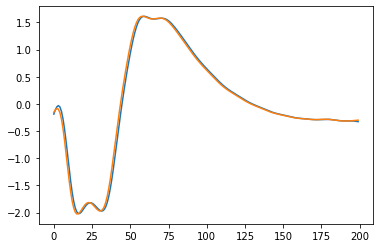

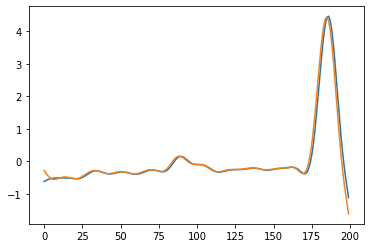

In [118]:
# plt.plot(train_labels)
# plt.show()
# plt.plot(test_labels)
# plt.show()

# plt.plot(seq_data[0])
# print(seq_labels[0])

# plt.ylim(-5, 5)
plt.plot(train_data[2000])
plt.plot(train_data[2001])
plt.show()

# plt.ylim(-5, 5)
plt.plot(test_data[2000])
plt.plot(test_data[2001])
plt.show()

Nothing (0)	128280	86.7812%
Left Wink (1)	6461	 4.3709%
Right Wink (2)	6896	 4.6651%
Dbl Blink (3)	6183	 4.1828%


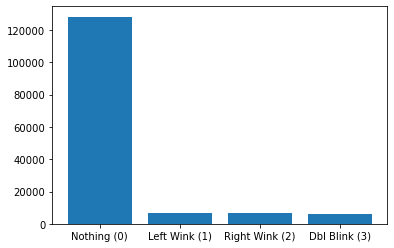

Nothing (0)	64834	86.9158%
Left Wink (1)	3555	 4.7658%
Right Wink (2)	3007	 4.0312%
Dbl Blink (3)	3198	 4.2872%


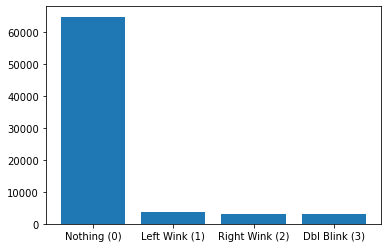

In [119]:
def labels_info(labels):
    # 0 for None, 1 for Left, 2 for Right
    bar_labels, bar_counts = np.unique(labels, return_counts=True)
    bar_labels = [f"{EVENT_ID_NAME_MAP[i]} ({i})" for i in bar_labels]

    for i,c in zip(bar_labels, bar_counts):
        print(f"{i}\t{c}\t{100*c/len(labels):7.4f}%")

    plt.bar(bar_labels, bar_counts)
    plt.show()

labels_info(train_labels)
labels_info(test_labels)

In [120]:
# BEST
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
    
    tf.keras.layers.Dropout(.50, input_shape=INPUT_SHAPE),
    
    tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(.2, input_shape=(16,)),

    tf.keras.layers.Dense(16, activation='relu'),

    tf.keras.layers.Dense(OUTPUT_SHAPE)
])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 200)               0         
                                                                 
 dropout_19 (Dropout)        (None, 200)               0         
                                                                 
 dense_46 (Dense)            (None, 64)                12864     
                                                                 
 dense_47 (Dense)            (None, 16)                1040      
                                                                 
 dense_48 (Dense)            (None, 4)                 68        
                                                                 
Total params: 13,972
Trainable params: 13,972
Non-trainable params: 0
_________________________________________________________________


In [103]:
# TEMP
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
    
    tf.keras.layers.Dropout(.25, input_shape=INPUT_SHAPE),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.2, input_shape=(64,)),

    tf.keras.layers.Dense(16, activation='relu'),

    tf.keras.layers.Dense(OUTPUT_SHAPE)
])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 200)               0         
                                                                 
 dropout_16 (Dropout)        (None, 200)               0         
                                                                 
 dense_40 (Dense)            (None, 64)                12864     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 16)                1040      
                                                                 
 dense_42 (Dense)            (None, 4)                 68        
                                                                 
Total params: 13,972
Trainable params: 13,972
Non-tra

In [121]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 50

history = model.fit(
    train_data,
    train_labels,
    epochs=EPOCHS,
    validation_data=(test_data, test_labels)
#     batch_size=16
)

Epoch 1/50
4620/4620 [==============================] - 7s 1ms/step - loss: 0.2249 - accuracy: 0.9229 - val_loss: 0.1871 - val_accuracy: 0.9402
Epoch 2/50
4620/4620 [==============================] - 6s 1ms/step - loss: 0.1604 - accuracy: 0.9415 - val_loss: 0.1712 - val_accuracy: 0.9457
Epoch 3/50
4620/4620 [==============================] - 6s 1ms/step - loss: 0.1457 - accuracy: 0.9453 - val_loss: 0.1770 - val_accuracy: 0.9450
Epoch 4/50
4620/4620 [==============================] - 6s 1ms/step - loss: 0.1371 - accuracy: 0.9485 - val_loss: 0.1612 - val_accuracy: 0.9452
Epoch 5/50
4620/4620 [==============================] - 6s 1ms/step - loss: 0.1332 - accuracy: 0.9497 - val_loss: 0.1690 - val_accuracy: 0.9455
Epoch 6/50
4620/4620 [==============================] - 6s 1ms/step - loss: 0.1270 - accuracy: 0.9514 - val_loss: 0.1679 - val_accuracy: 0.9452
Epoch 7/50
4620/4620 [==============================] - 6s 1ms/step - loss: 0.1257 - accuracy: 0.9517 - val_loss: 0.1687 - val_accuracy:

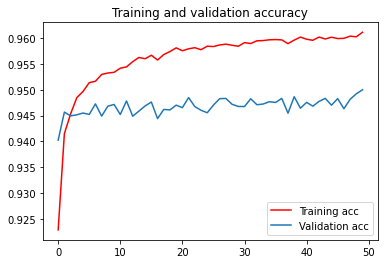

In [122]:
plt.plot(history.history['accuracy'], label='Training acc', color="red")
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Training and validation accuracy')
# plt.ylim(0.8)
plt.legend()

In [123]:
test_loss, test_acc = model.evaluate(
    test_data,
    test_labels,
    verbose=2
)

print('\nTest accuracy:', test_acc)

2332/2332 - 2s - loss: 0.1672 - accuracy: 0.9500 - 2s/epoch - 701us/step

Test accuracy: 0.9500094056129456


In [124]:
def print_confusion_matrix(data, labels):
    predictions = model.predict(data)
    predictions = tf.nn.softmax(predictions, axis=1)
    # print(predictions)

    event_pred = np.argmax(predictions, axis=1)
    # print(event_pred)

    # Rows are "real" labels
    # Columns are "predicted" labels
    conf = tf.math.confusion_matrix(
        labels,
        event_pred
    )
    print(conf)

    for i in range(len(conf)):
        letter = str(EVENT_ID_LETTER_MAP[i])[0]
        
        total = sum(conf[i])
        correct = conf[i][i]
        acc_total = 100*correct/total
        
        s = f"Event {letter} ({i}) accuracy: {correct:6}/{total: <6} (t_acc {acc_total:5.2f}%)"
        if i > 0:
            acc_event = 100*correct/(total - conf[i][0])
            s += f" (e_acc {acc_event:5.2f}%)"
        print(s)

print_confusion_matrix(train_data, train_labels)
print("")
print_confusion_matrix(test_data, test_labels)


tf.Tensor(
[[126278    964    682    356]
 [   654   5807      0      0]
 [   846      0   5986     64]
 [   651     17      6   5509]], shape=(4, 4), dtype=int32)
Event N (0) accuracy: 126278/128280 (t_acc 98.44%)
Event L (1) accuracy:   5807/6461   (t_acc 89.88%) (e_acc 100.00%)
Event R (2) accuracy:   5986/6896   (t_acc 86.80%) (e_acc 98.94%)
Event S (3) accuracy:   5509/6183   (t_acc 89.10%) (e_acc 99.58%)

tf.Tensor(
[[63287   697   415   435]
 [  493  3062     0     0]
 [  504     0  2495     8]
 [ 1025    50   102  2021]], shape=(4, 4), dtype=int32)
Event N (0) accuracy:  63287/64834  (t_acc 97.61%)
Event L (1) accuracy:   3062/3555   (t_acc 86.13%) (e_acc 100.00%)
Event R (2) accuracy:   2495/3007   (t_acc 82.97%) (e_acc 99.68%)
Event S (3) accuracy:   2021/3198   (t_acc 63.20%) (e_acc 93.01%)


In [62]:
predictions = model.predict(test_data)
predictions = tf.nn.softmax(predictions, axis=1)

pred_none = np.array([i[0] for i in predictions])
pred_left = np.array([i[1] for i in predictions])
pred_right = np.array([i[2] for i in predictions])
pred_select  = np.array([i[3] for i in predictions])

print(pred_none)
print(pred_left)
print(pred_right)
print(pred_select)



[0.9999865  0.9999739  0.9999417  ... 0.999907   0.99988604 0.999859  ]
[1.2509793e-07 8.7020226e-08 3.2994532e-08 ... 1.2062196e-07 8.5842188e-08
 8.8265374e-08]
[8.6180911e-08 7.0341173e-07 1.2835714e-05 ... 2.1492509e-05 2.3121251e-05
 2.9841774e-05]
[1.3267131e-05 2.5278259e-05 4.5497753e-05 ... 7.1334427e-05 9.0755530e-05
 1.1108171e-04]


In [63]:
event_pred = np.argmax(predictions, axis=1)
print(event_pred)

[0 0 0 ... 0 0 0]


In [103]:
DOWNSAMPLE_PRED = 3

pred_ma = np.array(predictions)
print(len(pred_ma), pred_ma)

# pred_ma = pred_ma[:len(pred_ma) - (len(pred_ma)%DOWNSAMPLE_PRED)]
# pred_ma = np.mean(pred_ma.reshape(-1,DOWNSAMPLE_PRED,4), 1)
# print(len(pred_ma), pred_ma)

event_pred = np.argmax(pred_ma, axis=1)
print(event_pred)

event_sel_high = (pred_select > 0.2)
event_pred &= np.invert(event_sel_high)
event_pred |= event_sel_high * 3



68249 [[9.5648599e-01 7.1945856e-03 3.6736326e-03 3.2645762e-02]
 [9.6294516e-01 7.2098565e-03 2.6087887e-03 2.7236219e-02]
 [9.6774465e-01 6.8996102e-03 1.7582574e-03 2.3597464e-02]
 ...
 [9.8832548e-01 5.0603383e-04 4.6919938e-03 6.4764675e-03]
 [9.8555911e-01 5.8185536e-04 7.2171944e-03 6.6418988e-03]
 [9.8229665e-01 6.2552019e-04 1.0180931e-02 6.8969429e-03]]
[0 0 0 ... 0 0 0]


In [64]:
# Plot the predictions alongside the actual ranges
# Looks to be 100% correct at least when deciding Left VS Right
# Mostly just the borders which are wrong (so not really an issue)

# Should add additional check which uses the output of this neural network itself as a feature.
# eg. The ANN needs to output "Left" or "Right" for 90% (or 50%?) of a sequence 0.1 seconds long.
def plot_prediction_probabilities(xlim_lower, xlim_upper):
    plt.figure(figsize=(14, 3), dpi=80)

    plt.plot(pred_none,  color=EVENT_COLOR_MAP[None], label=EVENT_ID_NAME_MAP[0])
    plt.plot(pred_left,  color=EVENT_COLOR_MAP["L"],  label=EVENT_ID_NAME_MAP[1])
    plt.plot(pred_right, color=EVENT_COLOR_MAP["R"],  label=EVENT_ID_NAME_MAP[2])
    plt.plot(pred_select, color=EVENT_COLOR_MAP["S"],  label=EVENT_ID_NAME_MAP[3])

    plt.xlim(xlim_lower, xlim_upper)
    plt.title("Model predicted probabilities")
    plt.legend()

    plt.show()

In [65]:
# True events
def plot_true_events(xlim_lower, xlim_upper):
    plt.figure(figsize=(14, 1), dpi=80)
    for i in range(4):
        x = np.array(range(len(test_labels)))[test_labels == i]
        y = test_labels[test_labels == i]/10
        plt.scatter(x, y, color=EVENT_COLOR_MAP[EVENT_ID_LETTER_MAP[i]], s=5)

    plt.xlim(xlim_lower, xlim_upper)
    plt.title("True events")
    plt.show()

In [66]:
# Final event predictions
def plot_pred_events(xlim_lower, xlim_upper):
    # Final preds
    plt.figure(figsize=(14, 1), dpi=80)
    for i in range(4):
        x = np.array(range(len(event_pred)))[event_pred == i]
        y = event_pred[event_pred == i]/10
        plt.scatter(x, y, color=EVENT_COLOR_MAP[EVENT_ID_LETTER_MAP[i]], s=5)

    plt.xlim(xlim_lower, xlim_upper)
    plt.title("Predicted events")
    plt.show()

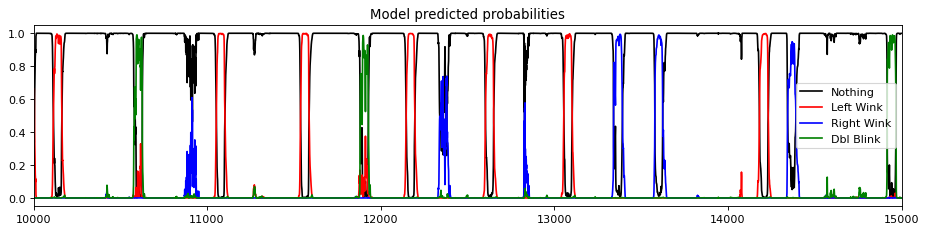

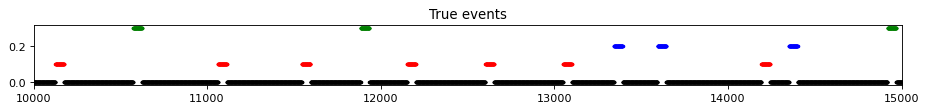

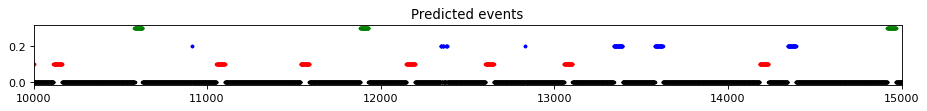

In [67]:
xlim_lower = 10000
xlim_upper = 15000

plot_prediction_probabilities(xlim_lower, xlim_upper)
plot_true_events(xlim_lower, xlim_upper)
plot_pred_events(xlim_lower, xlim_upper)

<Figure size 1120x160 with 0 Axes>

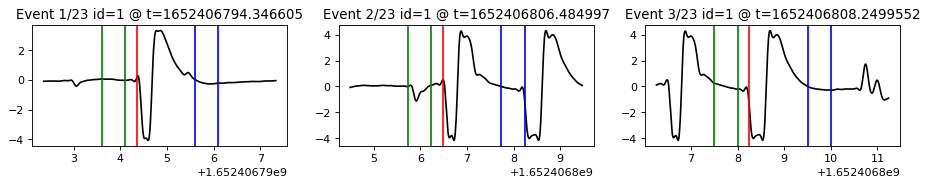

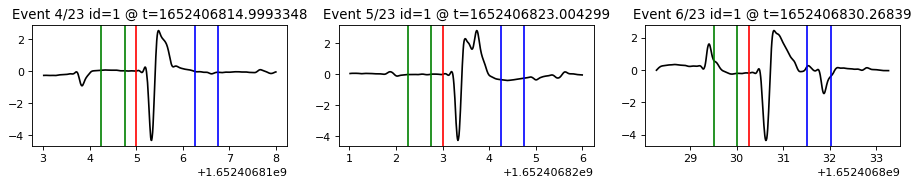

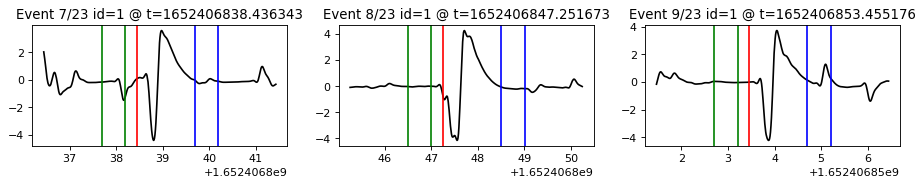

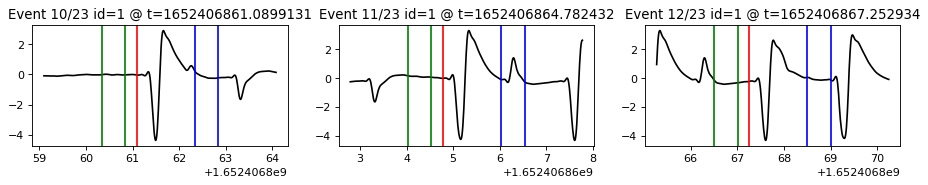

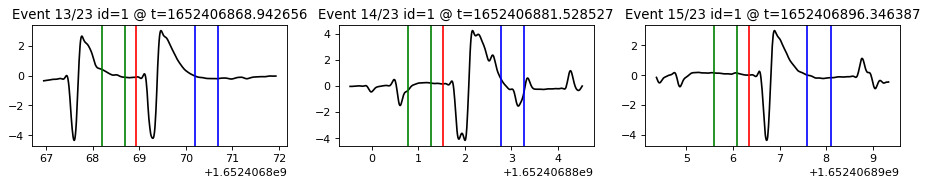

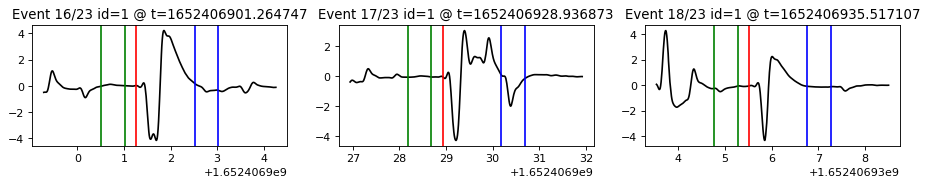

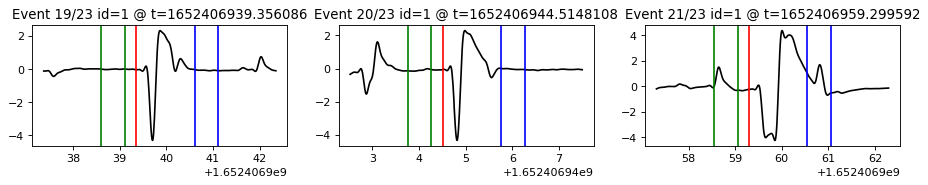

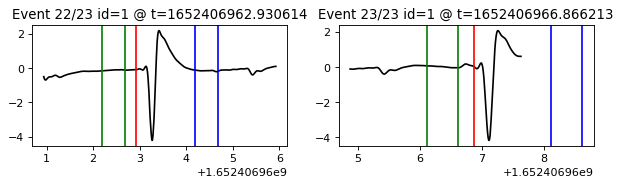

In [56]:
from data_load import load_sample_data, load_event_data, downsample
from data_transform import LP_Filter

# PLOT_FILE_NAME = FILE_NAMES_TRAIN[0]
# PLOT_FILE_NAME = FILE_NAMES_TEST[0]

# PLOT_FILE_NAME = "DATA_2022-05-12_Josh_0001_0_1652333343"

# PLOT_FILE_NAME = "DATA_2022-05-13_Josh_0001_3_1652400625"
# PLOT_FILE_NAME = "DATA_2022-05-13_Josh_0001_3_1652400939"
# PLOT_FILE_NAME = "DATA_2022-05-13_Josh_0001_4_1652401267"

PLOT_FILE_NAME = "DATA_2022-05-13_Josh_0001_7_1652406788"


samples_df = load_sample_data(SAMPLES_PATH + PLOT_FILE_NAME)
samples_df["sample"] = LP_Filter(samples_df["sample"], cutOff=7)
samples_df = downsample(samples_df, n=DOWNSAMPLE_RATE)

events_df = load_event_data(
    file_path = EVENTS_PATH + PLOT_FILE_NAME,
    event_id_map = EVENT_ID_MAP,
    event_color_map = EVENT_COLOR_MAP,
)

plot_samples_events_individual(
    samples_df, events_df, 
    event_id = 1,
    
    event_length = EVENT_LENGTH,
    event_start = EVENT_START,
    event_end = EVENT_END,
    
    event_sample_count = 500,
    event_sample_offset = -200,
)

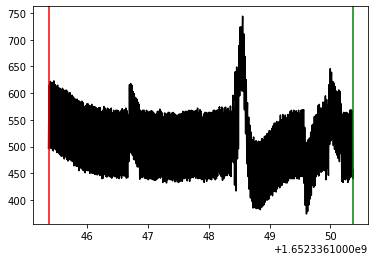

In [17]:
# PLOT_FILE_NAME = FILE_NAMES_TRAIN[2]
PLOT_FILE_NAME = FILE_NAMES_TEST[1]

samples_df = load_sample_data(SAMPLES_PATH + PLOT_FILE_NAME)
# samples_df = downsample(samples_df, n=DOWNSAMPLE_RATE)

ts = 1652336145.37
te = ts + 5
sint_df = samples_df[(samples_df["time_sec"] >= ts) & (samples_df["time_sec"] <= te)]

plt.plot(sint_df["time_sec"], sint_df["sample"], color="black")
plt.axvline(x=ts, color="red")
plt.axvline(x=te, color="green")
plt.show()

In [8]:
# PLOT_FILE_NAME = FILE_NAMES_TRAIN[2]
PLOT_FILE_NAME = FILE_NAMES_TEST[1]

samples_df = load_sample_data(SAMPLES_PATH + PLOT_FILE_NAME)
samples_df = downsample(samples_df, n=DOWNSAMPLE_RATE)

ts = 1652336145.37
te = t + 1
sint_df = samples_df[(samples_df["time_sec"] >= ts) & (samples_df["time_sec"] <= te)]

plt.plot(sint_df["time_sec"], sint_df["sample"], color="black")
plt.axvline(x=t, color="red")
plt.show()

NameError: name 't' is not defined

In [125]:
model.save("models/model_3_NoneReduce100.h5")

## Training Results

In [ ]:
30 epochs
50 might work too?

Epoch 30/30
4620/4620 [==============================] - 5s 1ms/step - 
loss: 0.1053 - accuracy: 0.9573 - val_loss: 0.1612 - val_accuracy: 0.9509
           
        
tf.Tensor(
[[126279    642    893    466]
 [   948   5485      0     28]
 [   725      0   6119     52]
 [   676      0     23   5484]], shape=(4, 4), dtype=int32)
Event N (0) accuracy: 126279/128280 (t_acc 98.44%)
Event L (1) accuracy:   5485/6461   (t_acc 84.89%) (e_acc 99.49%)
Event R (2) accuracy:   6119/6896   (t_acc 88.73%) (e_acc 99.16%)
Event S (3) accuracy:   5484/6183   (t_acc 88.69%) (e_acc 99.58%)

tf.Tensor(
[[63277   538   551   468]
 [  566  2989     0     0]
 [  410     0  2596     1]
 [  986     9   134  2069]], shape=(4, 4), dtype=int32)
Event N (0) accuracy:  63277/64834  (t_acc 97.60%)
Event L (1) accuracy:   2989/3555   (t_acc 84.08%) (e_acc 100.00%)
Event R (2) accuracy:   2596/3007   (t_acc 86.33%) (e_acc 99.96%)
Event S (3) accuracy:   2069/3198   (t_acc 64.70%) (e_acc 93.54%)
    
    
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
    tf.keras.layers.Dropout(.50, input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(.2, input_shape=(16,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_SHAPE)
])
    

FILE_NAMES_TRAIN = [
#     "DATA_2022-05-12_Josh_0001_0_1652333343",
#     "DATA_2022-05-12_Josh_0001_0_1652333800",
#     "DATA_2022-05-12_Josh_0001_1_1652334198",
#     "DATA_2022-05-12_Josh_0001_1_1652334982",
#     "DATA_2022-05-12_Josh_0001_2_1652335485",
#     "DATA_2022-05-12_Josh_0001_2_1652336009",
    
    "DATA_2022-05-13_Josh_0001_3_1652400625",
    "DATA_2022-05-13_Josh_0001_3_1652400939",
#     "DATA_2022-05-13_Josh_0001_4_1652401267",
#     "DATA_2022-05-13_Josh_0001_4_1652401740",
    "DATA_2022-05-13_Josh_0001_5_1652405337",
    "DATA_2022-05-13_Josh_0001_5_1652405637",
    "DATA_2022-05-13_Josh_0001_6_1652406023",
    "DATA_2022-05-13_Josh_0001_6_1652406202",
#     "DATA_2022-05-13_Josh_0001_7_1652406589",
#     "DATA_2022-05-13_Josh_0001_7_1652406788",
    "DATA_2022-05-13_Josh_0001_8_1652407331",
    "DATA_2022-05-13_Josh_0001_8_1652407508",
]

FILE_NAMES_TEST = [
#     "DATA_2022-05-12_Josh_0001_0_1652333343",
#     "DATA_2022-05-12_Josh_0001_0_1652333800",
#     "DATA_2022-05-12_Josh_0001_1_1652334198",
#     "DATA_2022-05-12_Josh_0001_1_1652334982",
#     "DATA_2022-05-12_Josh_0001_2_1652335485",
#     "DATA_2022-05-12_Josh_0001_2_1652336009",
    
#     "DATA_2022-05-13_Josh_0001_3_1652400625",
#     "DATA_2022-05-13_Josh_0001_3_1652400939",
    "DATA_2022-05-13_Josh_0001_4_1652401267",
    "DATA_2022-05-13_Josh_0001_4_1652401740",
#     "DATA_2022-05-13_Josh_0001_5_1652405337",
#     "DATA_2022-05-13_Josh_0001_5_1652405637",
#     "DATA_2022-05-13_Josh_0001_6_1652406023",
#     "DATA_2022-05-13_Josh_0001_6_1652406202",
    "DATA_2022-05-13_Josh_0001_7_1652406589",
    "DATA_2022-05-13_Josh_0001_7_1652406788",
#     "DATA_2022-05-13_Josh_0001_8_1652407331",
#     "DATA_2022-05-13_Josh_0001_8_1652407508",
]

EVENT_LENGTH = 2 # length of a given event sequence in seconds
EVENT_START = -0.75
EVENT_END = -0.25


NONE_EVENT = 1.00